# pg_server_cache 
Analyzing the PG Server cache. 
## Cells
- Configuration - a connection string
- Prereq - verify the extension pg_buffercache installed (assumes pg_stat_statements already installed)
- Total buffer size - total size of the buffer cache
- Buffer cache by DB - Show how many buffers each DB uses, using the view pg_buffercache. 

## Configuration
Open a connection to the DB. Use a Connection String stored in a .cfg file

In [8]:
import sqlalchemy
import psycopg2
import pandas as pd
import configparser
import matplotlib.pyplot as plt 

# Read from the Config file
config = configparser.ConfigParser() 
config.read_file(open(r'../ipynb.cfg'))

con_str = config.get('con_str', 'PG_AIRBASES') 

engine = sqlalchemy.create_engine(con_str)

# print("Connecting with engine " + str(engine))
try:
    connection = engine.connect()
except (Exception, sqlalchemy.exc.SQLAlchemyError) as error:
    print("Error while connecting to PostgreSQL database:", error)



## Pre-Req
Check whether the extension exists
TODO: The cell below doesn't really work. The query returns "false" but the code ignores it. Maybe it returns the string "false" rather than a bit

In [9]:

from sqlalchemy import create_engine
from sqlalchemy.exc import SQLAlchemyError

sql_command = """
SELECT CASE WHEN COUNT(*) > 0 THEN B'1'::BIT(1) ELSE B'0'::BIT(1) END AS extension_exists
FROM pg_extension
WHERE extname = 'pg_buffercache';
"""
df = pd.read_sql_query(sql_command, connection)

try:
    # Execute the SQL command
   
    result = connection.execute(sql_command).fetchone()

    # print (type(result[0]))
        # Check the result
    if result[0] == '0':
        raise ValueError("Error: The extension pg_buffercache doesn't exist ")
    else: 
        print ("The Extension pg_buffercache exists")
except (SQLAlchemyError, ValueError) as e:
    # Handle any errors or raised exceptions
    raise e


The Extension pg_buffercache exists


## Total Buffer Size
The ```pg_buffercache``` module provides a means for examining what's happening in the shared buffer cache in real time.
The module provides a C function pg_buffercache_pages that returns a set of records, plus a view pg_buffercache that wraps the function for convenient use. https://www.postgresql.org/docs/current/pgbuffercache.html. 
The total size of the buffer cache should be equal to the setting  ```shared_buffers``` ( Show shared_buffers)

In [10]:
qry_total_buffer_size = """
SELECT 
	count(*) as count_buffers, 
	count(*) * 8 as buffers_size_kb,
  pg_size_pretty(count(*) * 8) as buffer_size_pretty
FROM pg_buffercache;
"""

df = pd.read_sql_query(qry_total_buffer_size, connection)
df

,count_buffers,buffers_size_kb,buffer_size_pretty
0,243066,1944528,1899 kB


## Buffers used by Each DB
Shows how many buffers each db uses (as a number as in KB). It also shows the percentage of each DB buffers usage from total.
Resources: https://tomasz-gintowt.medium.com/postgresql-extensions-pg-buffercache-b38b0dc08000 

TODO: exclude non important databases such as template0, rdsadmin

In [11]:

qry_total_buffer_size = """
WITH total_num_of_buffers AS (
    SELECT count(*)  AS count_buffers
    FROM pg_buffercache
)
SELECT 
    d.datname AS db_name, 
    count(*) AS count_buffers,
    count(*) * 8 AS total_buffers_size_kb, 
    pg_size_pretty(count(*) * 8 * 1024) AS total_buffers_size,
    round((count(*)) * 100.0 / t.count_buffers, 2) AS percentage_of_total
FROM pg_buffercache b
INNER JOIN pg_database d ON b.reldatabase = d.oid
CROSS JOIN total_num_of_buffers t

GROUP BY d.datname, 
	t,count_buffers
ORDER BY d.datname;
"""

df = pd.read_sql_query(qry_total_buffer_size, connection)
df

,db_name,count_buffers,total_buffers_size_kb,total_buffers_size,percentage_of_total
0,airbases,76999,615992,602 MB,31.68
1,airbases-demo,85796,686368,670 MB,35.30
2,airbases-qa,76,608,608 kB,0.03
3,bh,422,3376,3376 kB,0.17
4,bh2,76,608,608 kB,0.03
5,books,82,656,656 kB,0.03
6,demo,77,616,616 kB,0.03
7,grafana_demo,82,656,656 kB,0.03
8,metis-qa-airbases,78,624,624 kB,0.03
9,platform-v2,78536,628288,614 MB,32.31


### Buffers used by each DB - Pie Chart

<Figure size 1000x600 with 0 Axes>

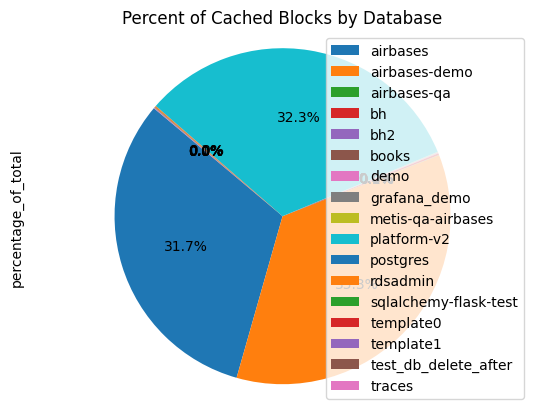

In [12]:
plt.figure(figsize=(10, 6))
df.plot.pie(y="percentage_of_total", autopct="%1.1f%%", startangle=140, labels=[None] * len(df))
plt.axis("equal")  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.title("Percent of Cached Blocks by Database")
plt.legend(labels=df["db_name"], loc="upper right")
plt.show()

## Databases Cache Hit Ratio
**Cache Hit Ratio** is a metric that quantifies the efficiency of a cache system. It represents the percentage of requested data or items that are successfully retrieved from the cache (hits) compared to the total number of requests made to the cache (hits plus misses). A higher cache hit ratio indicates that the cache is effectively reducing the need to access the slower, underlying data source, leading to improved system performance.The **Cache Hit Ratio** should be around 99%.  

Notice: The extension pg_stat_statements must be installed to query the table ```pg_stat_database```
- [pg_stat_database](https://www.postgresql.org/docs/current/monitoring-stats.html#MONITORING-PG-STAT-DATABASE-VIEW)
- The changes in the system view in every [PG version](https://pgstats.dev/pg_stat_database)

In [15]:
qry_database_activity = """
SELECT 
  datid as dbid, 
  datname as db_name, 
  blks_read, 
  blks_hit, 
  round(blks_hit / (blks_read + blks_hit)::numeric, 4) as cache_hit_ratio
FROM pg_stat_database
ORDER BY cache_hit_ratio DESC """ 
df = pd.read_sql_query(qry_database_activity, connection)
df

,dbid,db_name,blks_read,blks_hit,cache_hit_ratio
0,0,None,6155,233203112,1.0000
1,741903,bh,27835,277851149,0.9999
2,4,template0,1601,18792487,0.9999
3,742423,bh2,2351,18800102,0.9999
4,773210,traces,2902,20309440,0.9999
5,14301,postgres,3105,27616967,0.9999
6,27603,books,2760,27866746,0.9999
7,1,template1,2775,18855089,0.9999
8,2238988,grafana_demo,2935,25323590,0.9999
9,2407973,test_db_delete_after,2517,18812316,0.9999


## Tables (in a single DB) Cache Hit Ratio.
Postgres caches recent queries in memory called the shared buffer cache (shared_buffers in postgresql.conf). The pg_statio_user_tables has as rows representing various stats on each of the (user) tables. The two columns of interest we’ll be looking at are:

* pg_statio_user_tables.heap_blks_read — Number of disk blocks read from a table (ie. missed cache)
* pg_statio_user_tables.heap_blks_hits — Number of buffer hits from this table (ie. cache hit)

TODO: also show the actual table size and the actual size of the table in the buffer now. 

In [ ]:
query_ccnnections_metrics = """
SELECT 
  schemaname, 
  pg_class.relname, 
  ROUND(
    CASE 
      WHEN heap_blks_hit + heap_blks_read = 0 
      THEN 0 
      ELSE heap_blks_hit::decimal / (heap_blks_hit + heap_blks_read) 
    END, 
    3
  ) as cache_hit_ratio
FROM 
  pg_statio_user_tables 
  JOIN pg_class ON pg_statio_user_tables.relid = pg_class.oid 
  JOIN pg_namespace ON pg_namespace.oid = pg_class.relnamespace;
"""

df = pd.read_sql_query(query_ccnnections_metrics, connection)
df

,schemaname,relname,cache_hit_ratio
0,metis,pg_stat_database_snapshots,0.836
1,metis,queries,0.999
2,metis,pg_stat_tables_activity_snapshots,0.769
3,public,pg_settings_snapshot,0.987
4,cron,job,0.652
5,logs,postgres_logs,0.000
6,public,sales_table,0.982
7,metis,postgres_server_settings,0.000
8,metis_qa,test_high_indexes_num,0.000
9,postgres_air,aircraft,0.000
